### **5 Fold Cross Validation**
* Without validation 
* Binary classification
* Color transformation: RGB, R, G, B, RG, RB, GB, HSV, CMYK, CIElab, Gray scale, YUV


In [2]:
import torch
import cv2
import numpy as np
from random import shuffle
import os
from PIL import Image, ImageOps
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchsummary
from torchsummary import summary 
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, average_precision_score
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold
from IPython.display import display

In [ ]:
#Test gpu esta funcionando 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Reading RGB image paths

In [3]:
#Path
path_base = '/home/irarijimel/Documentos/CIC/Tesis/Sipakmed/'
folders_cell = ['Dyskeratotic','Koilocytotic','Metaplastic','Parabasal','Superficial-intermediate']
folders_mask = ['imagenes']

rgb_dir_anormal = []
rgb_dir_normal = []
for indice_cell in range(1,6):#cells file
    #print(indice_cell)
    for indice_mask in range(1,2):#mask file
        #print(indice_mask)
        path = path_base + folders_cell[indice_cell-1] + '/' + folders_mask[indice_mask-1] + '/'
        ele_img = os.listdir(path)
        ele_img.sort()#name files ex.['001_01_rsze.bmp', '001_02_rsze.bmp', '001_03_rsze.bmp', '001_04_rsze.bmp'...]
        print(len(ele_img))
        #print(ele_img)
        #rgb_images.append(path )
        if indice_cell==1 or indice_cell==2 or indice_cell==3:#carpetas de celulas anormales
            for i in range(len(ele_img)):#recorre todos los nombres y los guarda
                rgb_dir_anormal.append(path + ele_img[i])
        else:
            for i in range(len(ele_img)):#recorre todos los nombres y los guarda
                rgb_dir_normal.append(path + ele_img[i])

print('Anormal: ',len(rgb_dir_anormal))
print('Normal: ',len(rgb_dir_normal))

#print('Dir anormal: ',rgb_dir_anormal)
#print('Dir normal: ',rgb_dir_normal)

#tamaño de entrada
sia = 256
sib = 256


813
807
792
787
824
Anormal:  2412
Normal:  1611


In [4]:
#Built targets for each class
trg_anormal = []
trg_normal = []
trg1 = []
trg2 = []
trg3 = []
trg4 = []
trg5 = []
target_total = []
for indice_cell in range(1,6):
  path = path_base + folders_cell[indice_cell-1] +'/imagenes/'#solo guardo las img_rgb
  ele_img = os.listdir(path)
  #print(path)
  print('Indice: ',indice_cell)

  if indice_cell == 1:#abnormal cell
    trg1 = np.zeros((1,len(ele_img)),dtype=int)#etiquetas pra dyskeratotic
    print(trg1.shape)
    #print(trg1)
  elif indice_cell == 2:#abnormal cell
    trg2 = np.zeros((1,len(ele_img)),dtype=int)#etiquetas pra koilocytotic
    print(trg2.shape)
    #print(trg2)
  elif indice_cell == 3:#abnormal cell
    trg3 = np.zeros((1,len(ele_img)),dtype=int)#etiquetas pra metaplastic
    print(trg3.shape)
    #print(trg3)
  elif indice_cell == 4:#normal cell
    trg4 = np.ones((1,len(ele_img)),dtype=int)#etiquetas pra parabasal
    print(trg4.shape)
    #print(trg4)
  else:#normal cell
    trg5 = np.ones((1,len(ele_img)),dtype=int)#etiquetas pra superficial-intermediate
    print(trg5.shape)
    #print(trg5)


target_anormal = np.concatenate((trg1,trg2,trg3),axis=1)
target_anormal = np.transpose(target_anormal)

target_normal = np.concatenate((trg4,trg5),axis=1)
target_normal = np.transpose((target_normal))

print('Total de targets anormales: ',target_anormal.shape)
print('Total de targets normales: ',target_normal.shape)
#print(target_anormal)
#print(target_normal)

Indice:  1
(1, 813)
Indice:  2
(1, 807)
Indice:  3
(1, 792)
Indice:  4
(1, 787)
Indice:  5
(1, 824)
Total de targets anormales:  (2412, 1)
Total de targets normales:  (1611, 1)


In [5]:
#Balance the classes
d = list(zip(rgb_dir_anormal,target_anormal))#zip -> mix the three lists
shuffle(d)#random
rgb_dir_anormal,target_anormal = zip(*d)#separete the classes

rgb_dir_anormal = rgb_dir_anormal[0:len(rgb_dir_normal)]
target_anormal = target_anormal[0:len(target_normal)]

print(len(rgb_dir_anormal))
print(len(target_anormal))

#Tupla -> list
rgb_dir_anormal = list(rgb_dir_anormal)
print(type(rgb_dir_anormal))

#Join paths normal and abnormal
full_dir_rgb = rgb_dir_anormal + rgb_dir_normal


print('All paths RGB images: ',len(full_dir_rgb))
targets = np.concatenate((target_anormal,target_normal),axis=0)
print('All targets: ',targets.shape)
#print(targets)

target = np.transpose(targets)

1611
1611
<class 'list'>
All paths RGB images:  3222
All targets:  (3222, 1)


**Show random images**

(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

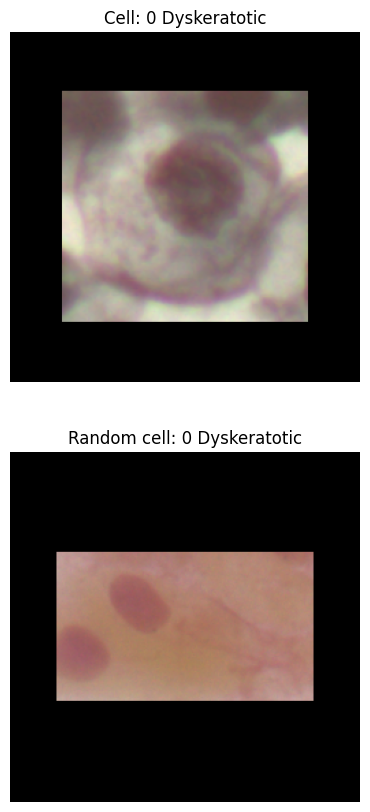

In [8]:
num_aleat1 = np.random.randint(0,high=3222-1)
num_aleat2 = np.random.randint(0,high=3222-1)

img = cv2.imread(full_dir_rgb[num_aleat1])
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].imshow(img)
aux = int(targets[num_aleat1].item())
ax[0].set_title(f'Cell: {aux} {folders_cell[aux]}')
ax[0].axis('off')

img = cv2.imread(full_dir_rgb[num_aleat2])
ax[1].imshow(img)
aux = int(targets[num_aleat1].item())
ax[1].set_title(f'Random cell: {aux} {folders_cell[aux]}')
ax[1].axis('off')

**Split train and test sets**

In [9]:
#Mix paths and split the dataset 80:20
shuffle_data = True  # shuffle the addresses before saving
if shuffle_data:
    d = list(zip(full_dir_rgb,targets))#zip -> miz the two lists
    shuffle(d)#random
    full_dir_rgb, target_total = zip(*d)#separete the elements

#Train paths
train_dir_rgb = full_dir_rgb[0:int(len(full_dir_rgb) * 0.80)]
train_target = target_total[0:int(len(target_total) * 0.8)]

#Test paths
test_dir_rgb = full_dir_rgb[(int(len(full_dir_rgb) * 0.80)):int(len(full_dir_rgb))]
test_target = target_total[(int(len(target_total) * 0.8)):int(len(target_total))]

print("V. train rgb: ",len(train_dir_rgb))
print("V. test rgb: ",len(test_dir_rgb))
print("V. total: ",len(train_dir_rgb)+len(test_dir_rgb))
print("Target train: ",len(train_target))
print("Target test: ",len(test_target))
print("Target total: ",len(train_target)+len(test_target))

#Targets to tensor
train_target = np.array(train_target)
test_target = np.array(test_target)

train_tensor = torch.tensor(train_target, dtype=torch.long)
test_tensor = torch.tensor(test_target, dtype=torch.long)

train_tensor = train_tensor.squeeze()#one dimension
test_tensor = test_tensor.squeeze()


V. train rgb:  2577
V. test rgb:  645
V. total:  3222
Target train:  2577
Target test:  645
Target total:  3222


In [10]:
print(test_tensor.shape)

torch.Size([645])


**Transformaciones**

In [11]:
#Train transforms
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [12]:
#Test transforms
transform_test = transforms.Compose([
    transforms.ToTensor()
])

In [13]:
#YUV color transformation
def yuv_space_model(img):
    img = np.asarray(img).astype(np.float32)

    #Normalize each channel
    img_nor = np.zeros_like(img)
    for c in range(3):
        c_min = img[:, :, c].min()
        c_max = img[:, :, c].max()
        img_nor[:, :, c] = (img[:, :, c] - c_min) / (c_max - c_min)

    img_nor_aux = Image.fromarray((img_nor * 255).astype(np.uint8))

    # Conversion RGB -> YUV
    T = np.array([
        [0.2990,  0.5870,  0.1140],
        [-0.1471, -0.2888, 0.4359],
        [0.6148, -0.5148, -0.1000]
    ])

    yuv_img = img_nor @ T.T 
    yuv_img_aux = Image.fromarray((yuv_img * 255).astype(np.uint8))

    return yuv_img, yuv_img_aux, img_nor_aux

torch.Size([256, 256, 3])
torch.Size([256, 256, 3])


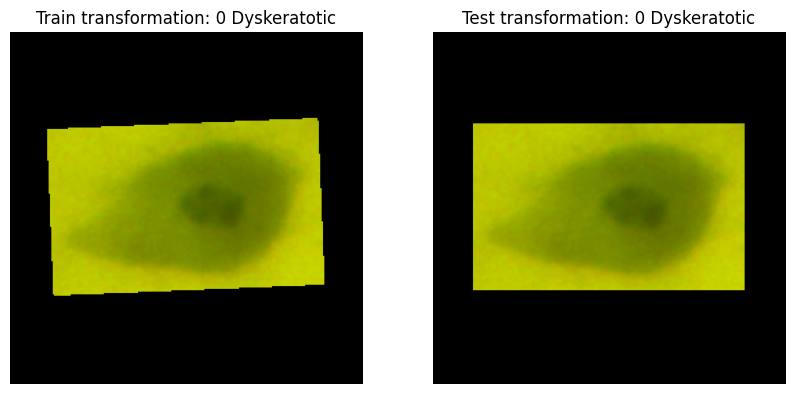

In [14]:
#Probe transformations and color spaces
num_aleat1 = np.random.randint(0,high=2577-1)
num_aleat2 = np.random.randint(0,high=645-1)

img = Image.open(train_dir_rgb[num_aleat1])
#img = img.convert('LAB')
#img = ImageOps.grayscale(img)
#img = img.getchannel('B')
#yuv_img, img, img_nor_aux = yuv_space_model(img)
#CODIGO PARA DOS CANALES 
arr = np.array(img)#convertimos a arreglo
r = arr[:,:,0]
g = arr[:,:,1]
b = arr[:,:,2]
new = np.zeros((256,256,3),dtype=np.uint8)
new[:,:,0] = g
new[:,:,1] = b
new[:,:,2] = 0
img = Image.fromarray(new)    
       

img1 = transform_train(img)
img1 = np.transpose(img1,(1,2,0))

fig, ax = plt.subplots(1,2,figsize=(10,10))
aux = int(target_total[num_aleat1].item())
ax[0].imshow(img1)
ax[0].set_title(f'Train transformation: {aux} {folders_cell[aux]}')
ax[0].axis('off')

print(img1.shape)

img1 = transform_test(img)
img1 = np.transpose(img1,(1,2,0))
aux = int(target_total[num_aleat1].item())
ax[1].imshow(img1)
ax[1].set_title(f'Test transformation: {aux} {folders_cell[aux]}')
ax[1].axis('off')

print(img1.shape)

**Create dataloader: TRAIN and TEST_VALIDATION**

In [17]:
#It is like a generator in tensorflow
class ImageDaset(Dataset):
    def __init__(self,dir_rgb,train_tensor,transform = None):
        self.dir_rgb = dir_rgb#paths
        self.train_tensor = train_tensor#targets
        self.transform = transform#transformations 

    def __len__(self):
        #Lenght of dataset
        return len(self.dir_rgb)
    
    def __getitem__(self, idx):
        #Returns an image and target
        rgb_path = self.dir_rgb[idx]#path

        #Get target
        label = self.train_tensor[idx]

        #Image processing
        img = Image.open(rgb_path)

        #COLOR TRANSFORMATION
        #img1=img#RGB
        #_,img1,_ = yuv_space_model(img)YUV
        #img1 = img.convert('LAB')#LAB, CMYK, HSV
        #img1 = ImageOps.grayscale(img)
        #img1 = img.getchannel('B')

        #Two channels RG, RG, GB
        arr = np.array(img)#convert to array
        r = arr[:,:,0]
        g = arr[:,:,1]
        b = arr[:,:,2]
        new = np.zeros((256,256,2),dtype=np.uint8)
        new[:,:,0] = g
        new[:,:,1] = b
        img1 = Image.fromarray(new, mode='LA')    
       
        #Applay transformations
        if self.transform:
            img = self.transform(img1)


        return img,label


In [18]:
#Reset weight funtion
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [19]:
#Model
class BMaskCNN(nn.Module):
    def __init__(self, num_class):
        super(BMaskCNN, self).__init__()

        self.cov1c = nn.Conv2d(2,32,kernel_size=5,stride=1,padding='valid')
        self.bch1c = nn.BatchNorm2d(32)
        self.rel1c = nn.ReLU()
        self.avg1c = nn.MaxPool2d(kernel_size=3, stride=1)

        self.cov2c = nn.Conv2d(32,64,kernel_size=3,stride=2,padding='valid')
        self.bch2c = nn.BatchNorm2d(64)
        self.rel2c = nn.ReLU()
        self.avg2c = nn.MaxPool2d(kernel_size=3, stride=1)

        self.c3 = nn.Conv2d(64,128,kernel_size=5,stride=2,padding='valid')
        self.bch3 = nn.BatchNorm2d(128)
        self.rel3 = nn.ReLU()
        self.avg3 = nn.MaxPool2d(kernel_size=3,stride=2)

        self.c4 = nn.Conv2d(128,128,kernel_size=3,stride=2,padding='valid')
        self.bch4 = nn.BatchNorm2d(128)
        self.rel4 = nn.ReLU()
        self.avg4 = nn.MaxPool2d(kernel_size=3,stride=1)
        
        #Fully connected 
        self.fc1 = nn.Linear(128*12*12,1000)
        self.rel1 = nn.ReLU()
        self.dr1 = nn.Dropout(0.5)

        #self.fc2 = nn.Linear(2000,510)
        #self.rel2 = nn.ReLU()
        #self.dr2 = nn.Dropout(0.3)

        self.fc3 = nn.Linear(1000,128)
        self.rel33 = nn.ReLU()

        self.fcout = nn.Linear(128,num_class)

    def forward(self, x1):
        #imagen rgb
        x1 = self.avg1c(self.rel1c(self.bch1c(self.cov1c(x1))))
        x1 = self.avg2c(self.rel2c(self.bch2c(self.cov2c(x1))))

        #Seguir con las convoluciones
        x3 = self.avg3(self.rel3(self.bch3(self.c3(x1))))
        x4 = self.avg4(self.rel4(self.bch4(self.c4(x3))))

        #flatten
        x = torch.flatten(x4, start_dim=1)
        
        #Capas fully connected
        x5 = (self.rel1(self.fc1(x)))
        #x6 = self.dr2(self.rel2(self.fc2(x5)))
        x7 =self.rel33(self.fc3(x5))
        outputs = self.fcout(x7)    

        return outputs

        

In [20]:
#Create a model instance
model = BMaskCNN(num_class=2)
model = model.to(device)#model to gpu

NameError: name 'device' is not defined

In [21]:
input1_size = (2,256,256)
summary(model, input_size=[input1_size])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 252, 252]           1,632
       BatchNorm2d-2         [-1, 32, 252, 252]              64
              ReLU-3         [-1, 32, 252, 252]               0
         MaxPool2d-4         [-1, 32, 250, 250]               0
            Conv2d-5         [-1, 64, 124, 124]          18,496
       BatchNorm2d-6         [-1, 64, 124, 124]             128
              ReLU-7         [-1, 64, 124, 124]               0
         MaxPool2d-8         [-1, 64, 122, 122]               0
            Conv2d-9          [-1, 128, 59, 59]         204,928
      BatchNorm2d-10          [-1, 128, 59, 59]             256
             ReLU-11          [-1, 128, 59, 59]               0
        MaxPool2d-12          [-1, 128, 29, 29]               0
           Conv2d-13          [-1, 128, 14, 14]         147,584
      BatchNorm2d-14          [-1, 128,

In [22]:
#General configurations
k_folds = 5#k-folds
num_epochs = 200
batch = 32
criterion = torch.nn.CrossEntropyLoss()  # loss function
results_train = {}
results_test = {}
torch.manual_seed(42)


In [23]:
#Join paths
dataset = train_dir_rgb + test_dir_rgb
targets = torch.cat((train_tensor,test_tensor),0)

print('Tamaño de dataset: ', len(dataset))
print('Tamaño de targets: ', targets.shape)

Tamaño de dataset:  3222
Tamaño de targets:  torch.Size([3222])


In [ ]:
#5-fold cross validation 
kfold = KFold(n_splits=k_folds, shuffle=False)
loss_total = []
acc_total = []
predictions_total = []
labels_total = []
dataset_total = list(range(len(dataset)))
for fold,(train_ids, test_ids) in enumerate(kfold.split(dataset_total)):
    print(f'Fold {fold}')
    print('------------------------')

    #Build datasets with different transformations
    train_dataset = ImageDaset(dataset, targets, transform=transform_train)
    test_dataset = ImageDaset(dataset, targets, transform=transform_test)

    #Build subsets
    train_subset = Subset(train_dataset, train_ids)
    test_subset = Subset(test_dataset, test_ids)

    #DataLoaders
    train_dataloader = DataLoader(train_subset, batch_size=batch, shuffle=True)
    test_dataloader = DataLoader(test_subset, batch_size=batch, shuffle=False)

    model.apply(reset_weights)
    optimizer = torch.optim.Adam(model.parameters())# lr=1e-3)

    loss_train = []
    acc_train = []
    #Train loop
    for epoch in range(num_epochs):
        # Modo entrenamiento
        model.train()
        correct = 0
        total = 0
        running_loss = 0.0
        for batch_idx, (images1, labels) in enumerate(train_dataloader):
            # Move data (GPU or CPU)
            images1,labels = images1.to(device), labels.to(device)

            outputs = model(images1)

            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            #Calculate correct predictions
            _, predicted = torch.max(outputs, 1)  # Index
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            if batch_idx % 10 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_dataloader)}], Loss: {loss.item():.4f}")

        # Calculat accuracy for each epoch
        epoch_loss = running_loss / len(train_dataloader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")

        loss_train.append(epoch_loss)
        acc_train.append(accuracy)
        results_train[fold] = accuracy#save last acc

    loss_total.append(loss_train)
    acc_total.append(acc_train)

    print(f'Train {fold} finish. Save model')
    model_name_fold = f'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Modelos_y_Dataloder/cross_{fold}_binary_GB.pth'
    torch.save(model.state_dict(), model_name_fold) 
    
    #Train fisnish, start test
    correct = 0
    total = 0
  
    all_predictions = []
    all_labels = []

    with torch.no_grad():  
        for images1, labels in test_dataloader:
            
            images1, labels = images1.to(device), labels.to(device)

            outputs = model(images1)

            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            #save predictions
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    #Accuaracy
    #average_loss = test_loss / len(test_dataloader)
    accuracy = 100 * correct / total
    

    print(f"Test Accuracy: {accuracy:.2f}%")
    print('----------------------------')
    results_test[fold] = accuracy
    #Calcular matri de confucsion y guardarla
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    predictions_total.append(all_predictions)#estoy gurdando la info y despues puedo hacer las matrices 
    labels_total.append(all_labels)
    #cm = metrics.confusion_matrix(all_labels, all_predictions)
    #cm_total[fold]
    

#Show all acc for each fold
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results_test.items():
    print(f'Fold {key}: {value} %')
    sum += value
print(f'Average: {sum/len(results_test.items())} %')

    

        


Fold 0
------------------------
Reset trainable parameters of layer = Conv2d(2, 32, kernel_size=(5, 5), stride=(1, 1), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=valid)
Reset trainable parameters of layer = BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Reset trainable parameters of layer = Linear(in_features=18432, out_features=100

In [ ]:
#Save dataloader
torch.save(test_dataloader,'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Modelos_y_Dataloder/dataloader_test_binary_gb.pth')
torch.save(train_dataloader,'/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Modelos_y_Dataloder/dataloader_train_binary_gb.pth')


In [ ]:
#Average acc TRAIN
f1 = acc_total[0]
f2 = acc_total[1]
f3 = acc_total[2]
f4 = acc_total[3]
f5 = acc_total[4]
prom_acc_train = (f1[-1]+f2[-1]+f3[-1]+f4[-1]+f5[-1])/5
print('Average acc trian: ',prom_acc_train)

Promedio acc de trian:  99.3327318436982


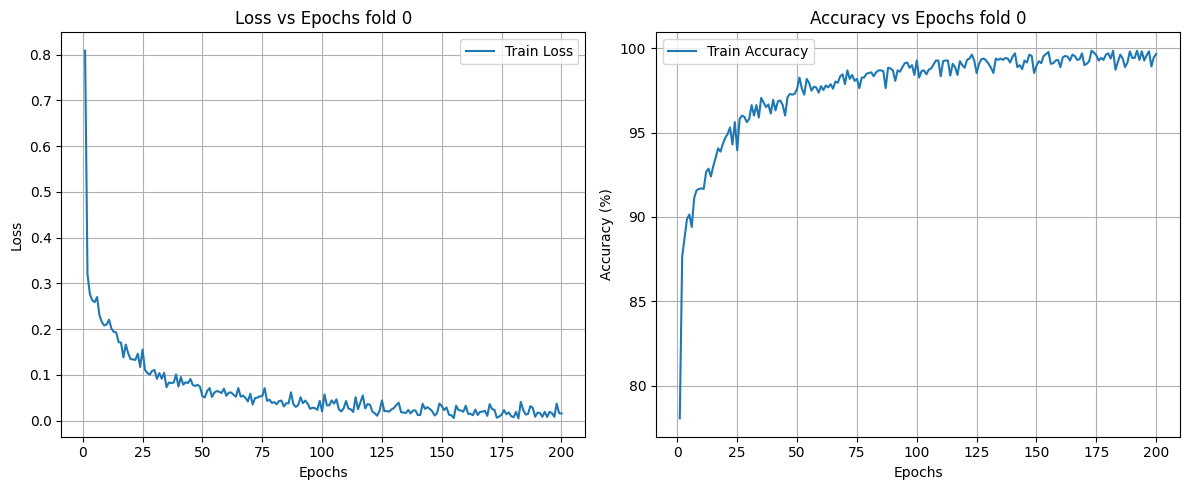

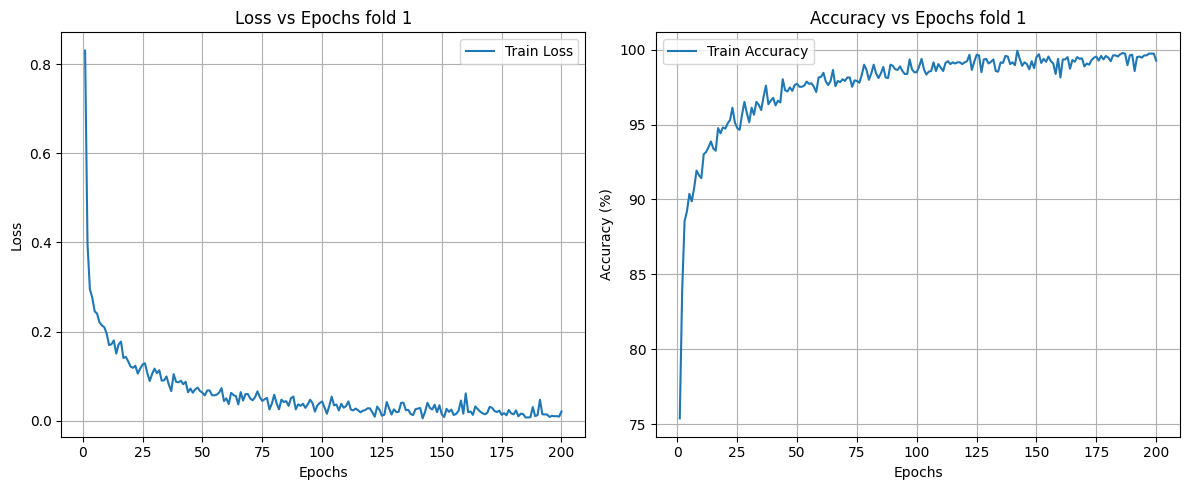

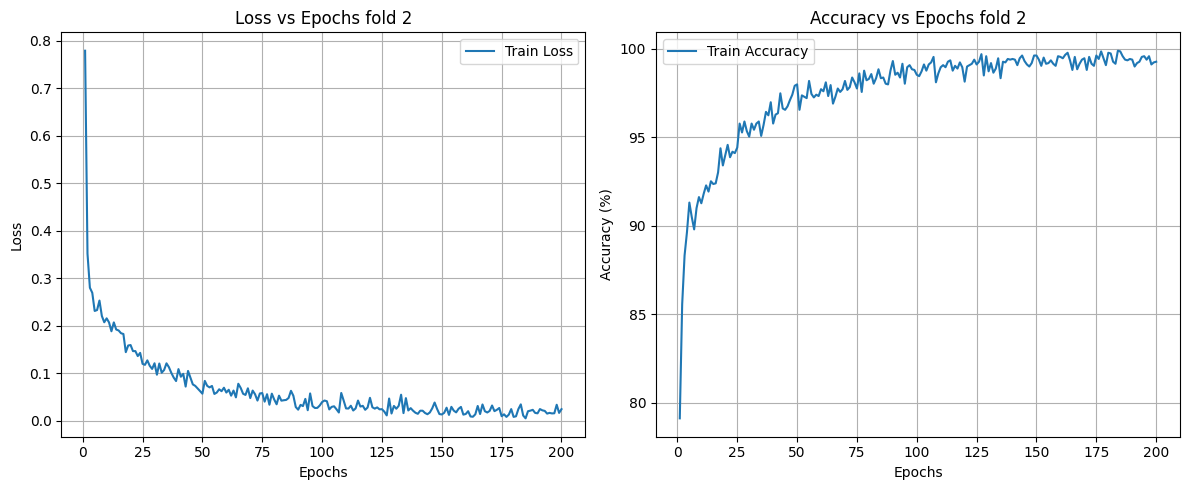

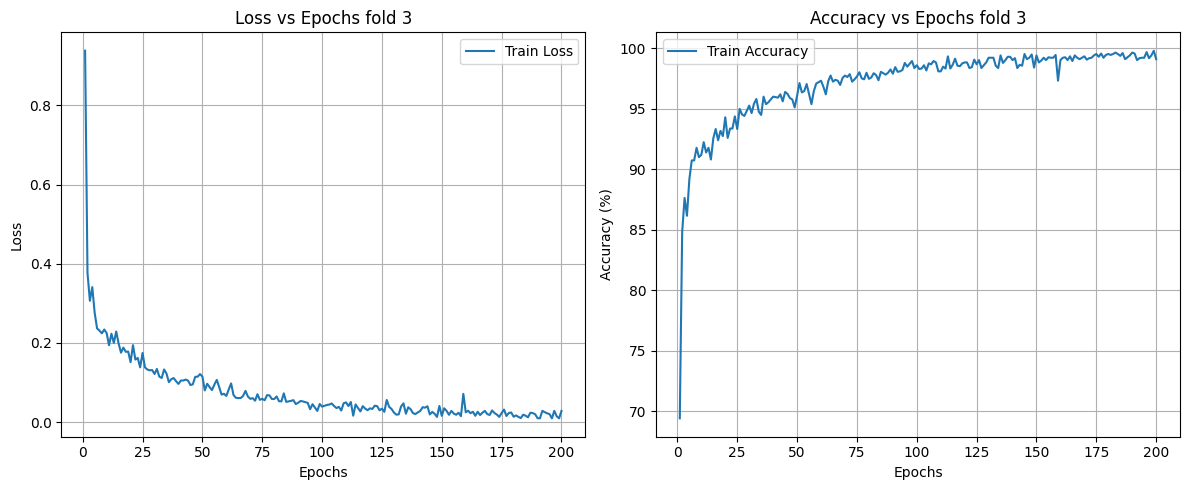

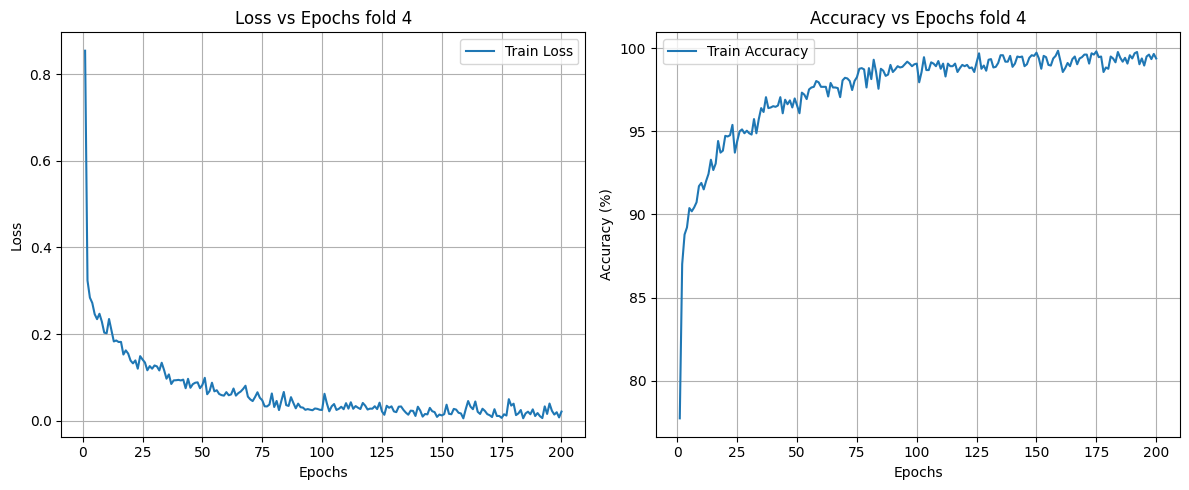

In [ ]:
#Show loss and acc grapghs

for fold in range(len(loss_total)):
    plt.figure(figsize=(12, 5))
    
    #Loss
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), loss_total[fold], label="Train Loss")
    #plt.plot(range(1, num_epochs + 1), loss_val, label="Validation Loss", linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"Loss vs Epochs fold {fold}")
    plt.legend()
    plt.grid(True)

    #Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), acc_total[fold], label="Train Accuracy")
    #plt.plot(range(1, num_epochs + 1), acc_val, label="Validation Accuracy", linestyle='--')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")                                                                                                                                                                                          
    plt.title(f"Accuracy vs Epochs fold {fold}")
    plt.legend()
    plt.grid(True)
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Loss/loss_acc_gb{fold}.jpg", bbox_inches='tight')


    plt.tight_layout()
    plt.show()


### Confusion matrices TEST

**Confusion matrixes with decimals**

MATRIZ DE CONFUSION DE CADA FOLD


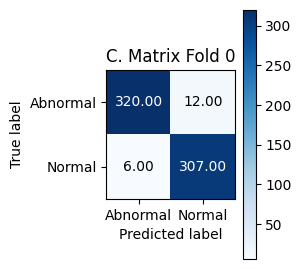

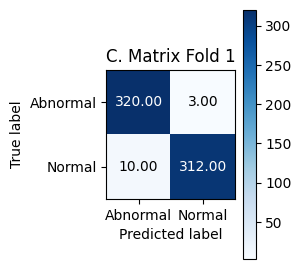

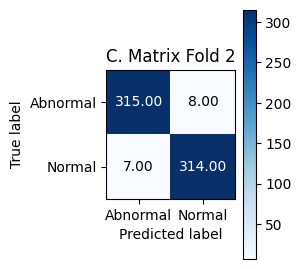

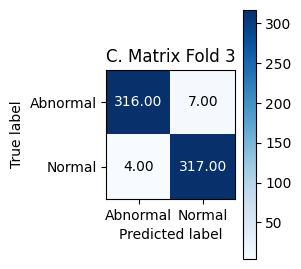

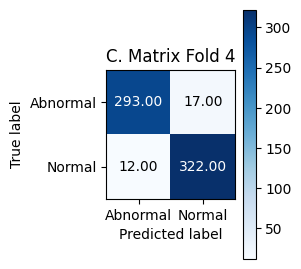

In [ ]:
#Confusion matrixes for each fold
print("MATRIZ DE CONFUSION DE CADA FOLD")
target_names = ['Abnormal','Normal']
cm_normalized_total_ORG = np.zeros((2,2))#matriz de conf original

for fold in range(len(predictions_total)):
    cm = metrics.confusion_matrix(labels_total[fold], predictions_total[fold])                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      
    #print(cm)
    #cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_normalized = cm
    cm_normalized_total_ORG = cm_normalized + cm_normalized_total_ORG
    fig, ax = plt.subplots(figsize=(3,3))                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=target_names, yticklabels=target_names,
        title=f'C. Matrix Fold {fold}',
        ylabel='True label',
        xlabel='Predicted label')

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
            
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Matrix/matrix_gb{fold}.jpg", bbox_inches='tight')
    fig.tight_layout()
    plt.show()


**Average confiusion matrices wuth decimals**

MATRIZ DE CONFUSION PROMEDIO
[[312.8   9.4]
 [  7.8 314.4]]


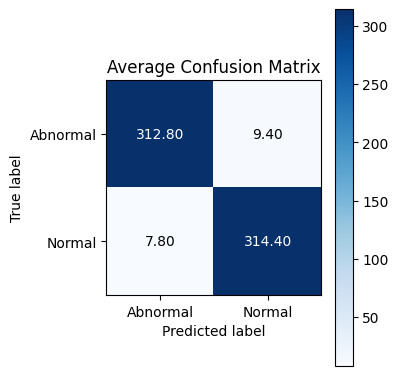

In [25]:
#Matriz de confusion promedio con decimales
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = cm_normalized_total_ORG/5
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='Average Confusion Matrix',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Matrix/matrix_promedio_decimales_gb.jpg", bbox_inches='tight')
    
fig.tight_layout()
plt.show()

**Average confusion matrixes withput decimals**

MATRIZ DE CONFUSION PROMEDIO
[[313.   9.]
 [  8. 314.]]


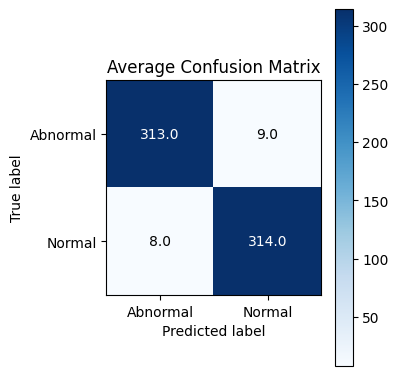

In [26]:
#Matriz de confusion promedio con decimales
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = np.round(cm_normalized_total_ORG/5)
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='Average Confusion Matrix',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j]),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Matrix/matrix_promedio_sin_decimales_gb.jpg", bbox_inches='tight')

fig.tight_layout()
plt.show()

MATRIZ DE CONFUSION DE CADA FOLD


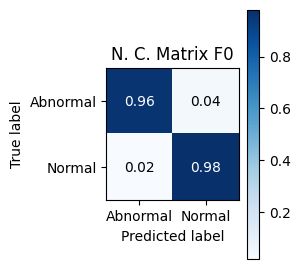

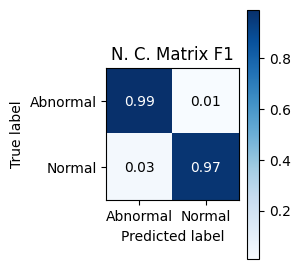

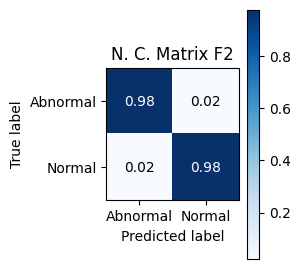

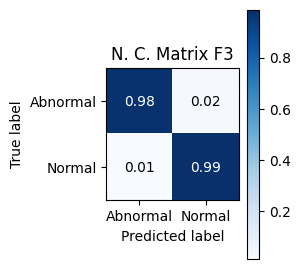

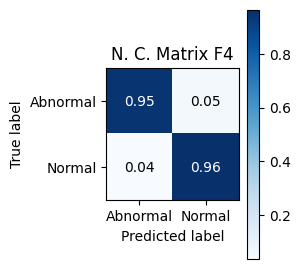

In [27]:
#vamos a visualizar todas las matrices de confusion para cada fold 
print("MATRIZ DE CONFUSION DE CADA FOLD")
cm_normalized_total_ORG = np.zeros((2,2))

for fold in range(len(predictions_total)):
    cm = metrics.confusion_matrix(labels_total[fold], predictions_total[fold])
    #print(cm)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    #cm_normalized = cm
    cm_normalized_total_ORG = cm_normalized + cm_normalized_total_ORG
    fig, ax = plt.subplots(figsize=(3,3))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=target_names, yticklabels=target_names,
        title=f'N. C. Matrix F{fold}',
        ylabel='True label',
        xlabel='Predicted label')

    fmt = '.2f'
    thresh = cm_normalized.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm_normalized[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm_normalized[i, j] > thresh else "black")
            
    plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Matrix/matrix_gb_Nor{fold}.jpg", bbox_inches='tight')
    fig.tight_layout()
    plt.show()

MATRIZ DE CONFUSION PROMEDIO
[[0.97065783 0.02934217]
 [0.02408426 0.97591574]]


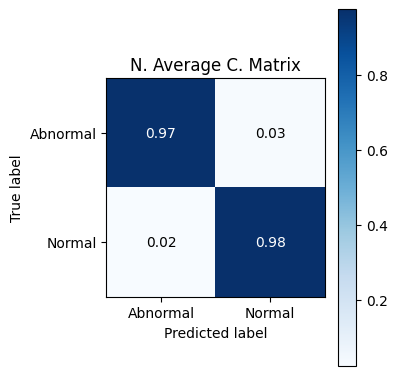

In [29]:
#matriz de confusion promedio 
print("MATRIZ DE CONFUSION PROMEDIO")
cm_normalized_total = cm_normalized_total_ORG/5
print((cm_normalized_total))
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm_normalized_total, interpolation='nearest', cmap=plt.cm.Blues)
ax.figure.colorbar(im, ax=ax)

ax.set(xticks=np.arange(cm.shape[1]),
    yticks=np.arange(cm.shape[0]),
    xticklabels=target_names, yticklabels=target_names,
    title='N. Average C. Matrix',
    ylabel='True label',
    xlabel='Predicted label')

fmt = '.2f'
thresh = cm_normalized_total.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm_normalized_total[i, j], fmt),
                ha="center", va="center",
                color="white" if cm_normalized_total[i, j] > thresh else "black")
        
plt.savefig(f"/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Matrix/matrix_promedio_gb_Nor.jpg", bbox_inches='tight')
    
fig.tight_layout()
plt.show()

In [30]:
#Obtener las metricas de cada fold
print("METRICAS DE CADA FOLD")
precision_total = np.zeros((1,2))
recalll_total = np.zeros((1,2))
f1_total = np.zeros((1,2))
accuracy_total = 0
for fold in range(len(predictions_total)):
    precision_total = precision_score(labels_total[fold],predictions_total[fold],average=None) + precision_total
    recalll_total = recall_score(labels_total[fold],predictions_total[fold],average=None) + recalll_total
    f1_total = f1_score(labels_total[fold],predictions_total[fold],average=None) + f1_total
    accuracy_total = accuracy_score(labels_total[fold],predictions_total[fold]) + accuracy_total

    report = classification_report(labels_total[fold],predictions_total[fold], target_names=target_names)
    print(report)
    
    with open("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Reportes_cross_validation/reportes_crossval_gb.txt", "a") as f:
        f.write(f"===== Fold {fold} =====\n")
        f.write(report)
        f.write("\n\n")  # espacio entre folds

METRICAS DE CADA FOLD
              precision    recall  f1-score   support

    Abnormal       0.98      0.96      0.97       332
      Normal       0.96      0.98      0.97       313

    accuracy                           0.97       645
   macro avg       0.97      0.97      0.97       645
weighted avg       0.97      0.97      0.97       645

              precision    recall  f1-score   support

    Abnormal       0.97      0.99      0.98       323
      Normal       0.99      0.97      0.98       322

    accuracy                           0.98       645
   macro avg       0.98      0.98      0.98       645
weighted avg       0.98      0.98      0.98       645

              precision    recall  f1-score   support

    Abnormal       0.98      0.98      0.98       323
      Normal       0.98      0.98      0.98       321

    accuracy                           0.98       644
   macro avg       0.98      0.98      0.98       644
weighted avg       0.98      0.98      0.98       64

In [31]:
#Metricas promedio
print("METRICAS PROMEDIO")
print("Precision: ",precision_total/5)
print("Recall: ",recalll_total/5)
print("F1-score: ",f1_total/5)
print("Accuracy: ",accuracy_total/5)

with open("/home/irarijimel/Documentos/CIC/Tesis/Prueba_mascaras2/5_fold_binary/Reportes_cross_validation/reportes_crossval_gb.txt", "a") as f:
    f.write(f"===== Average =====\n")
    f.write(f'Precision: {precision_total/5}\n')
    f.write(f'Recall: {recalll_total/5}\n')
    f.write(f'F1-score: {f1_total/5}\n')
    f.write(f'Accuracy: {accuracy_total/5}\n')
    f.write("\n\n")

METRICAS PROMEDIO
Precision:  [[0.97554173 0.9712523 ]]
Recall:  [[0.97065783 0.97591574]]
F1-score:  [[0.97304373 0.97352755]]
Accuracy:  0.97330685155761
